# QDAC-II virtual gates


In [1]:
from time import sleep
import numpy as np
from IPython.display import Image, display
from qcodes_contrib_drivers.drivers.QDevil import QDAC2
qdac_addr = '192.168.8.17'
qdac = QDAC2.QDac2('QDAC', visalib='@py', address=f'TCPIP::{qdac_addr}::5025::SOCKET')
import qcodes.instrument_drivers.rigol.DS1074Z as DS1000Z
rigol_addr = '192.168.8.199'
scope = DS1000Z.DS1074Z('rigol', visalib='@py', address=f'TCPIP::{rigol_addr}::INSTR')

Connected to: QDevil QDAC-II (serial:3, firmware:10-1.4) in 0.21s
Connected to: RIGOL TECHNOLOGIES DS1104Z (serial:DS1ZA171812151, firmware:00.04.03) in 0.04s


In [2]:
scope.write('*rst')
qdac.reset()

In [3]:
def capture():
    scope.write('stop')
    scope.write(":disp:data?")
    bmpdata = scope.visa_handle.read_raw()[2+9:]
    image = Image(data=bmpdata)
    display(image)

In [4]:
# Connect osc ch 1 to qdac ch 4 ("plunger4")
scope.write('chan1:disp on')
scope.write('chan1:bwl on')
scope.write('chan1:prob 1')
scope.write('chan1:scal 0.2')
scope.write('chan1:offs 0.0')
# Connect osc ch 2 to qdac ch 2 ("plunger2")
scope.write('chan2:disp on')
scope.write('chan2:bwl on')
scope.write('chan2:prob 1')
scope.write('chan2:scal 0.2')
scope.write('chan2:offs 0.0')
# Connect osc ch 3 to qdac ch 3 ("plunger3")
scope.write('chan3:disp on')
scope.write('chan3:bwl on')
scope.write('chan3:prob 1')
scope.write('chan3:scal 0.2')
scope.write('chan3:offs 0.0')
# Connect osc ch 4 to qdac out trigger 4 ("dmm")
scope.write('chan4:disp on')
scope.write('chan4:bwl on')
scope.write('chan4:prob 1')
scope.write('chan4:scal 1')
scope.write('chan4:offs -2')
scope.write('trig:edge:sour chan2')
scope.write('trig:edge:level 0')
scope.write('tim:scal 20e-6')
scope.write('tim:offs 60e-6')

In [5]:
arrangement = qdac.arrange(
        # QDAC channels 1, 2, 3, 4 connected to sample
        gates={'sensor1': 1, 'plunger2': 2, 'plunger3': 3, 'plunger4': 4},
        # DMM external trigger connected to QDAC Output Trigger 4
        output_triggers={'dmm': 4})

In [6]:
# Start without correction
arrangement.set_virtual_voltage('plunger4', 0.1)
sweep = arrangement.virtual_sweep2d(
        inner_gate='plunger2',
        inner_voltages=np.linspace(-0.2, 0.6, 5),
        outer_gate='plunger3',
        outer_voltages=np.linspace(-0.7, 0.15, 4),
        inner_step_time_s=10e-6,
        inner_step_trigger='dmm')

In [7]:
scope.write('sing')
sleep(4)
sweep.start()

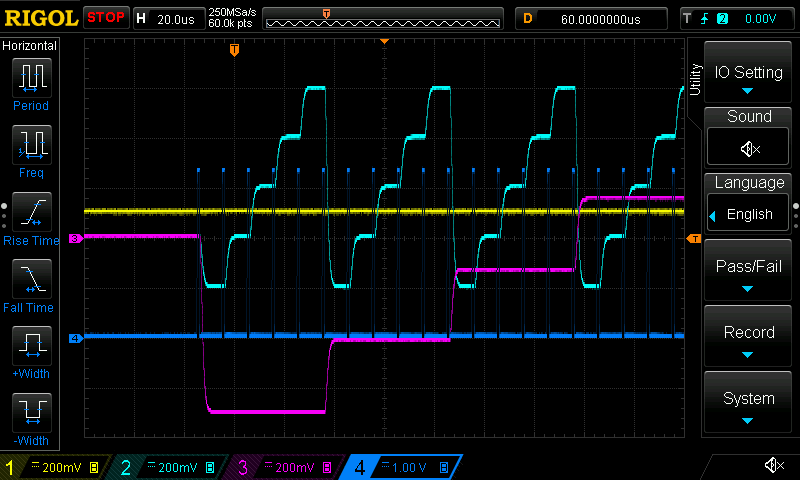

In [8]:
sleep(2)
capture()

In [9]:
print(sweep.actual_values_V('plunger4'))
print(sweep.actual_values_V('plunger2'))
print(sweep.actual_values_V('plunger3'))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[-0.2  0.   0.2  0.4  0.6 -0.2  0.   0.2  0.4  0.6 -0.2  0.   0.2  0.4
  0.6 -0.2  0.   0.2  0.4  0.6]
[-0.7        -0.7        -0.7        -0.7        -0.7        -0.41666667
 -0.41666667 -0.41666667 -0.41666667 -0.41666667 -0.13333333 -0.13333333
 -0.13333333 -0.13333333 -0.13333333  0.15        0.15        0.15
  0.15        0.15      ]


In [10]:
# Add corrections
arrangement.initiate_correction('plunger4', [1.0, 0.1, 0.05, -0.02])
arrangement.initiate_correction('plunger2', [-0.2, 0.98, 0.3, 0.06])
arrangement.initiate_correction('plunger3', [0.01, 0.41, 1.0, 0.15])
sweep = arrangement.virtual_sweep2d(
        inner_gate='plunger2',
        inner_voltages=np.linspace(-0.2, 0.6, 5),
        outer_gate='plunger3',
        outer_voltages=np.linspace(-0.7, 0.15, 4),
        inner_step_time_s=10e-6,
        inner_step_trigger='dmm')

In [11]:
scope.write('sing')
sleep(4)
sweep.start()

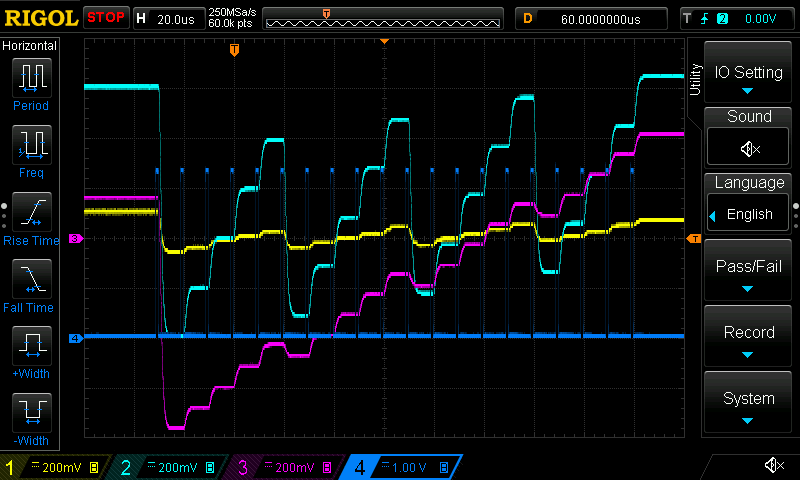

In [12]:
sleep(2)
capture()

In [13]:
print(sweep.actual_values_V('plunger4'))
print(sweep.actual_values_V('plunger2'))
print(sweep.actual_values_V('plunger3'))

[-0.057      -0.037      -0.017       0.003       0.023      -0.04283333
 -0.02283333 -0.00283333  0.01716667  0.03716667 -0.02866667 -0.00866667
  0.01133333  0.03133333  0.05133333 -0.0145      0.0055      0.0255
  0.0455      0.0655    ]
[-0.4   -0.204 -0.008  0.188  0.384 -0.315 -0.119  0.077  0.273  0.469
 -0.23  -0.034  0.162  0.358  0.554 -0.145  0.051  0.247  0.443  0.639]
[-0.767      -0.685      -0.603      -0.521      -0.439      -0.48366667
 -0.40166667 -0.31966667 -0.23766667 -0.15566667 -0.20033333 -0.11833333
 -0.03633333  0.04566667  0.12766667  0.083       0.165       0.247
  0.329       0.411     ]
